In [2]:
import xarray as xr
import xroms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
'''


FS: 10th jan 2024

- Returning to my work, I have to adapt and check the consistency of this script to use with the diagnostic file
- Also test in a few rows and so I can calculate by hand the values
- I have than to play with the variables and do the same calculations I did using Neils scripts as reference
* When all of this it is sorted out, organize the script to run using all the files on Katana
* Ask Colette to run the model with diagnostic output. 










'''

'\n\n\nFS: 10th jan 2024\n\n- Returning to my work, I have to adapt and check the consistency of this script to use with the diagnostic file\n- Also test in a few rows and so I can calculate by hand the values\n- I have than to play with the variables and do the same calculations I did using Neils scripts as reference\n* When all of this it is sorted out, organize the script to run using all the files on Katana\n* Ask Colette to run the model with diagnostic output. \n\n\n\n\n\n\n\n\n\n\n'

In [4]:
# I can't read the diagnostic file with xroms due to the lacking of some variables it needs to calculate other variables.
# Thus, I am using the average file to get grid metrics information to be used during heat budget calculation
ds_metric = xroms.open_netcdf('/mnt/c/Users/z5392640/OneDrive - UNSW/Documents/PhD/scientific_topics/heat_budget/neil_nci/colette/outer_avg.nc')
ds = xr.open_dataset('/mnt/c/Users/z5392640/OneDrive - UNSW/Documents/PhD/scientific_topics/heat_budget/neil_nci/colette/outer_dia.nc')
# ds, dg

In [5]:
# # # Selecting a small area
# xi_slice = slice(60, 160)
# eta_slice = slice(0, 50)

# # New area
# xi_slice = slice(40, 140)
# eta_slice = slice(0, -50)

# This is how we get the whole domain
xi_slice = slice(None, None)
eta_slice = slice(None, None)

lat_rho = ds["lat_rho"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
lon_rho = ds["lon_rho"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
lat_u = ds["lat_u"].isel(eta_u=eta_slice, xi_u=xi_slice)
lon_u = ds["lon_u"].isel(eta_u=eta_slice, xi_u=xi_slice)
lat_v = ds["lat_v"].isel(eta_v=eta_slice, xi_v=xi_slice)
lon_v = ds["lon_v"].isel(eta_v=eta_slice, xi_v=xi_slice)
pm = ds["pm"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
pn = ds["pn"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
h = ds["h"].isel(eta_rho=eta_slice, xi_rho=xi_slice)

area=np.divide(1,pm*pn)

In [6]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272,
                    eta_psi: 316, xi_psi: 271, ocean_time: 30)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 1994-02-01 ... 1994-03-02
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/139)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    salt_hdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_xdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_ydiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_sdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_vdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_rate      (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
Attributes: (12/34)
    file:              outer_dia.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS diagnostics file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Thursday - November 23, 2023 -...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...

In [7]:
ds.lon_u

<xarray.DataArray 'lon_u' (eta_u: 317, xi_u: 271)>
[85907 values with dtype=float64]
Coordinates:
    lon_u    (eta_u, xi_u) float64 ...
    lat_u    (eta_u, xi_u) float64 ...
Dimensions without coordinates: eta_u, xi_u
Attributes:
    long_name:      longitude of U-points
    units:          degree_east
    standard_name:  longitude
    field:          lon_u, scalar

In [8]:
# Getting the values where we have nan to use as mask
land_mask = np.isnan(ds.temp_hadv.isel(ocean_time=0, s_rho=-1, eta_rho=eta_slice, xi_rho=xi_slice))

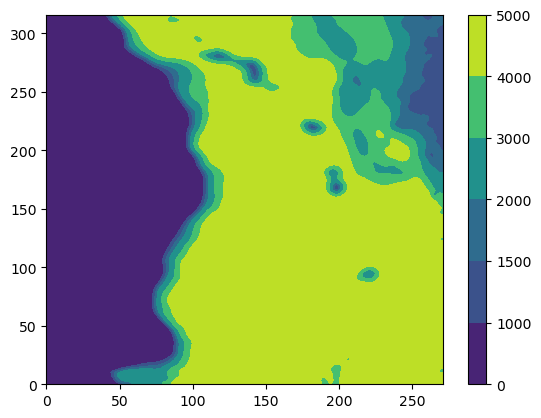

In [9]:
# Using the mask
# dg.temp.isel(ocean_time=0, s_rho=-1).where(~land_mask).where(h <= 200).isel(eta_rho=slice(30, -50), xi_rho=slice(30, -170)).plot(y='lat_rho', x='lon_rho')
h = h.where(~land_mask)
plt.contourf(h, levels=[0, 1000, 1500, 2000, 3000, 4000, 5000])
plt.colorbar()

In [10]:
# Fill in land with zeros:
h = h.fillna(0)
# h.where(h<=200).plot()


/tmp/ipykernel_412/2530893891.py:17: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in sc.collections:


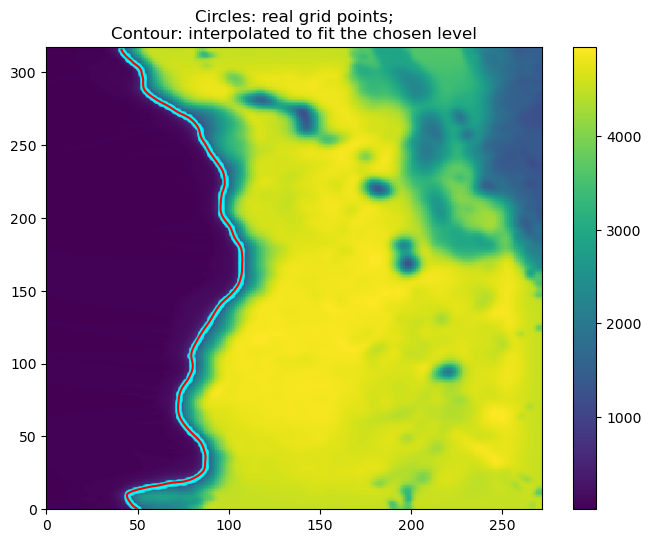

In [11]:
# Contours and grid does not perfectly match because the contour can be anything, and so, it is interpolated.
contour_depth = 1000.

x_var = lon_rho
y_var = lat_rho

fig = plt.figure(figsize = (8, 6))
# count = 165 # contour 87 for 2000m isobath, 165 for 1500m
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth], colors='red')
plt.contourf(h, levels=[0, 1000, 1500, 2000, 3000, 4000, 5000])
plt.pcolor(h)
plt.colorbar()
for collection in sc.collections:
    for path in collection.get_paths():
        # print(collection.get_paths())

        # count += 1
        # if count ==  212:
        # Write down the lat/lon indices
        for ii in range(np.size(path.vertices[:,0])):
            if int(np.round(path.vertices[ii][0])) < 125:   #FS added to select only the shelf break contour
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=15, alpha=0.5, color='cyan');
plt.title('Circles: real grid points;\nContour: interpolated to fit the chosen level');

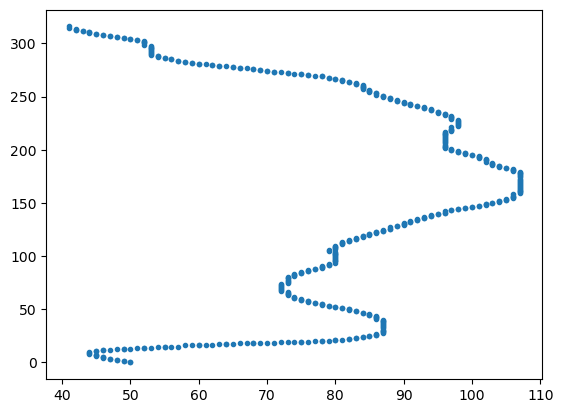

In [12]:
plt.plot(x_contour, y_contour, '.');


In [13]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)


In [14]:
x_contour, y_contour

([41,
  41,
  42,
  42,
  42,
  43,
  43,
  44,
  44,
  44,
  45,
  45,
  46,
  46,
  47,
  47,
  48,
  48,
  49,
  49,
  50,
  50,
  51,
  51,
  52,
  52,
  52,
  52,
  52,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  54,
  54,
  54,
  55,
  55,
  56,
  56,
  57,
  57,
  58,
  58,
  59,
  59,
  60,
  60,
  61,
  62,
  62,
  63,
  63,
  64,
  65,
  65,
  66,
  66,
  67,
  68,
  68,
  69,
  69,
  70,
  70,
  71,
  71,
  72,
  73,
  73,
  74,
  75,
  75,
  76,
  76,
  77,
  78,
  78,
  79,
  79,
  80,
  80,
  81,
  81,
  81,
  82,
  82,
  83,
  83,
  83,
  84,
  84,
  84,
  84,
  84,
  84,
  85,
  85,
  85,
  85,
  86,
  86,
  86,
  87,
  87,
  87,
  88,
  88,
  88,
  89,
  89,
  89,
  90,
  90,
  90,
  91,
  91,
  91,
  92,
  92,
  93,
  93,
  93,
  94,
  94,
  94,
  95,
  95,
  95,
  96,
  96,
  96,
  97,
  97,
  97,
  97,
  97,
  98,
  98,
  98,
  98,
  98,
  98,
  98,
  97,
  97,
  97,
  97,
  97,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96

In [15]:
diff_x_contour, diff_y_contour

(array([ 0,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,
         1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
         0,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,
         0,  1,  0,  1,  0,  1,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,
         0,  1,  0,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
         0,  0,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
         0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,
         0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,
         0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

In [16]:
# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)


In [17]:
#if both diff_y_contour and diff_x_contour == 0, means duplicate point
diff_ind

[3,
 5,
 7,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 25,
 31,
 40,
 43,
 45,
 47,
 49,
 51,
 53,
 56,
 58,
 61,
 63,
 66,
 68,
 70,
 72,
 75,
 78,
 80,
 83,
 85,
 87,
 89,
 92,
 95,
 99,
 104,
 107,
 110,
 113,
 117,
 120,
 122,
 125,
 128,
 131,
 133,
 136,
 140,
 153,
 158,
 171,
 175,
 178,
 180,
 183,
 186,
 190,
 194,
 197,
 200,
 203,
 207,
 225,
 231,
 235,
 237,
 240,
 242,
 245,
 247,
 249,
 251,
 253,
 256,
 258,
 261,
 264,
 267,
 270,
 273,
 276,
 279,
 282,
 284,
 287,
 290,
 294,
 297,
 300,
 304,
 312,
 320,
 324,
 327,
 330,
 333,
 336,
 339,
 343,
 359,
 363,
 366,
 368,
 371,
 373,
 376,
 378,
 380,
 382,
 385,
 387,
 390,
 393,
 398,
 408,
 413,
 415,
 417,
 419,
 421,
 424,
 427,
 431,
 439,
 444,
 449,
 455,
 459,
 463,
 467,
 469,
 474,
 477,
 480,
 482,
 484,
 486]

In [18]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [19]:
x_contour, y_contour

([41,
  41,
  42,
  42,
  43,
  44,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  52,
  52,
  52,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  54,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  81,
  82,
  83,
  83,
  84,
  84,
  84,
  84,
  84,
  85,
  85,
  85,
  86,
  86,
  87,
  87,
  88,
  88,
  89,
  89,
  90,
  90,
  91,
  91,
  92,
  93,
  93,
  94,
  94,
  95,
  95,
  96,
  96,
  97,
  97,
  97,
  97,
  98,
  98,
  98,
  98,
  98,
  98,
  98,
  97,
  97,
  97,
  97,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  97,
  97,
  98,
  98,
  99,
  99,
  100,
  101,
  101,
  101,
  102,
  102,
  102,
  103,
  103,
  103,
  104,
  104,
  105,
  106,
  106,
  106,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,


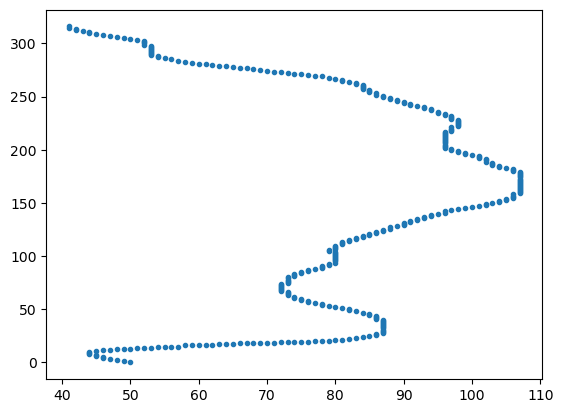

In [20]:
plt.plot(x_contour, y_contour, '.');

In [21]:
# Getting the bathymetry for the contour
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

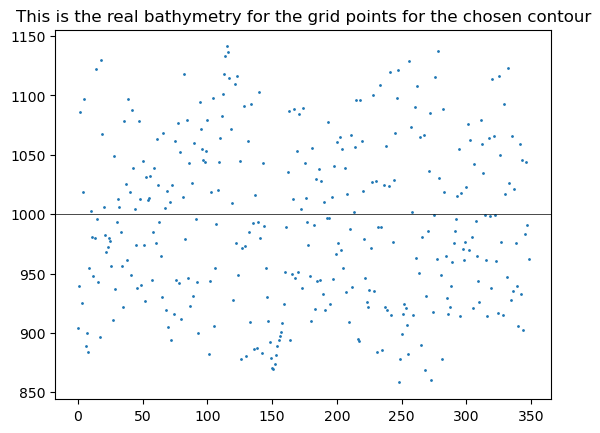

In [22]:
plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);
plt.title('This is the real bathymetry for the grid points for the chosen contour');

In [23]:
# Choose whether you want your contour on the u or t grid.
x_var = lon_rho
y_var = lat_rho

x_var, y_var


(<xarray.DataArray 'lon_rho' (eta_rho: 317, xi_rho: 272)>
 [86224 values with dtype=float64]
 Coordinates:
     lon_rho  (eta_rho, xi_rho) float64 ...
     lat_rho  (eta_rho, xi_rho) float64 ...
 Dimensions without coordinates: eta_rho, xi_rho
 Attributes:
     long_name:      longitude of RHO-points
     units:          degree_east
     standard_name:  longitude
     field:          lon_rho, scalar,
 <xarray.DataArray 'lat_rho' (eta_rho: 317, xi_rho: 272)>
 [86224 values with dtype=float64]
 Coordinates:
     lon_rho  (eta_rho, xi_rho) float64 ...
     lat_rho  (eta_rho, xi_rho) float64 ...
 Dimensions without coordinates: eta_rho, xi_rho
 Attributes:
     long_name:      latitude of RHO-points
     units:          degree_north
     standard_name:  latitude
     field:          lat_rho, scalar)

In [24]:
# # Getting lat and lon from the indexes
# lat_along_contour = np.zeros((len(x_contour)))
# lon_along_contour = np.zeros((len(x_contour)))

# # FS why do we need -1 here???
# for ii in range(len(h_contour)):
#     # print(ii-1)
#     # lon_along_contour[ii] = x_var[y_contour[ii-1],x_contour[ii-1]]
#     # lat_along_contour[ii] = y_var[y_contour[ii-1],x_contour[ii-1]]
#     lon_along_contour[ii] = x_var[y_contour[ii],x_contour[ii]]
#     lat_along_contour[ii] = y_var[y_contour[ii],x_contour[ii]]    

In [25]:
# lon_along_contour, lat_along_contour 

In [26]:
# FS: My method. I think it is safer because I am informing the dimensions to be used, instead of selection columns...
lat_along_contour = list()
lon_along_contour = list()
for xx, yy in zip(x_contour, y_contour):
    lon_along_contour.append(x_var.isel(xi_rho=xx, eta_rho=yy).values)
    lat_along_contour.append(y_var.isel(xi_rho=xx, eta_rho=yy).values)


lon_along_contour, lat_along_contour

([array(153.93666372),
  array(153.920019),
  array(153.92807221),
  array(153.91142613),
  array(153.9194126),
  array(153.92732858),
  array(153.91068483),
  array(153.91853397),
  array(153.92631253),
  array(153.93402046),
  array(153.94165771),
  array(153.94922423),
  array(153.95671996),
  array(153.96414486),
  array(153.97149888),
  array(153.95487972),
  array(153.93825555),
  array(153.92162637),
  array(153.92892059),
  array(153.91229011),
  array(153.8956546),
  array(153.87901405),
  array(153.86236845),
  array(153.84571778),
  array(153.82906203),
  array(153.81240119),
  array(153.79573524),
  array(153.77906419),
  array(153.78632121),
  array(153.76964882),
  array(153.77683858),
  array(153.78390974),
  array(153.79099522),
  array(153.79809508),
  array(153.80520938),
  array(153.81233818),
  array(153.83612703),
  array(153.84328104),
  array(153.85044968),
  array(153.87426152),
  array(153.88145559),
  array(153.88866444),
  array(153.91249939),
  array(153.919

In [27]:
# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)
# FS: is this the same approach for my contour orientation??
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

In [28]:
lat_along_contour

array([-25.47414036, -25.51648937, -25.56694911, -25.60929812,
       -25.65973012, -25.71013438, -25.75248339, -25.8028599 ,
       -25.85320866, -25.90352968, -25.95382295, -26.00408848,
       -26.05432627, -26.10453631, -26.1547186 , -26.19706762,
       -26.23941663, -26.28176564, -26.33192019, -26.3742692 ,
       -26.41661822, -26.45896723, -26.50131624, -26.54366525,
       -26.58601427, -26.62836328, -26.67071229, -26.7130613 ,
       -26.76318811, -26.80553712, -26.85563618, -26.90569208,
       -26.95574799, -27.00580389, -27.05585979, -27.10591569,
       -27.11362258, -27.16367849, -27.21373439, -27.22144128,
       -27.27149718, -27.32155308, -27.32925997, -27.37931587,
       -27.42937178, -27.47942768, -27.52948358, -27.53719047,
       -27.58724637, -27.63730228, -27.64500917, -27.69506507,
       -27.74512097, -27.75282786, -27.80288376, -27.85293967,
       -27.90299557, -27.94534458, -27.99540048, -28.04545638,
       -28.0878054 , -28.1378613 , -28.18021031, -28.22

In [29]:
# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

contour_mask = h*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1

contour_mask_numbered = contour_mask

In [30]:
contour_mask_numbered[0], contour_mask_numbered[-2]

(<xarray.DataArray 'h' (xi_rho: 272)>
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 349.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,


Text(0.5, 1.0, 'Contour numbered')

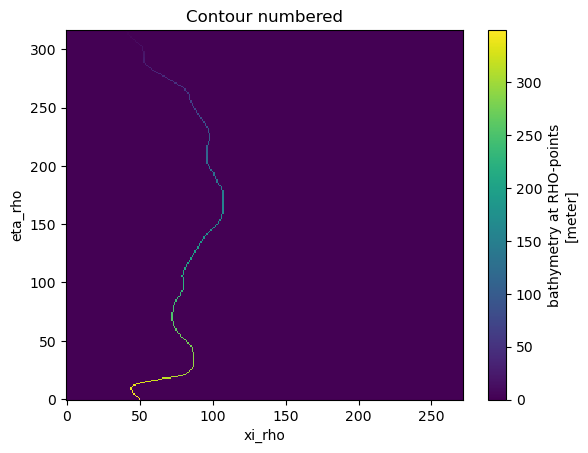

In [31]:
contour_mask_numbered.plot()
plt.title('Contour numbered')

Text(0.5, 1.0, 'Position to start masking')

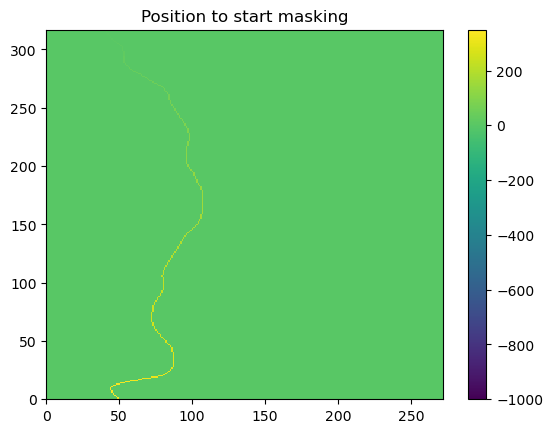

In [32]:
# FS to see what happens here
mask_value = -1000
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, -1] = mask_value

plt.pcolor(contour_masked_above)
plt.colorbar()
plt.title('Position to start masking')

In [33]:
#Create mask
# fill in one cell to the top east of the contour with value mask_value:I want offshore waters to be == -1000 and landward to be == 0
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, -1] = mask_value

# The next loops will check the masks numbers (-1000 or 0) starting from
# the four corners of the domain. The one that will actually do all the work
# for my domain (FS speaking) is the first, "from top left" 

# from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1
    for jj in range(len(contour_mask[:, 0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if west of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

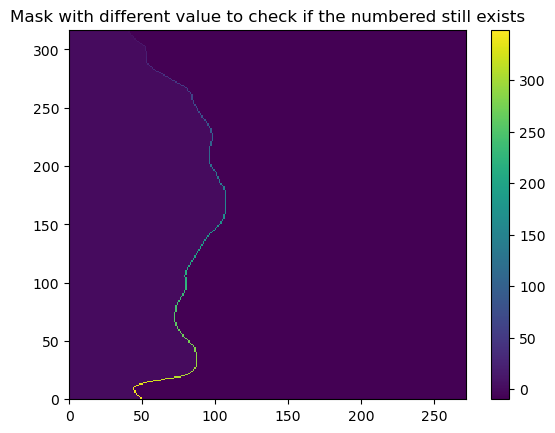

In [34]:
# FS just changing the filling value to check the numbered contour...created a temporary variable for that
contour_masked_above_tmp = np.where(contour_masked_above !=-1000, contour_masked_above, -10)
plt.pcolor(contour_masked_above_tmp)
plt.colorbar()
plt.title('Mask with different value to check if the numbered still exists');

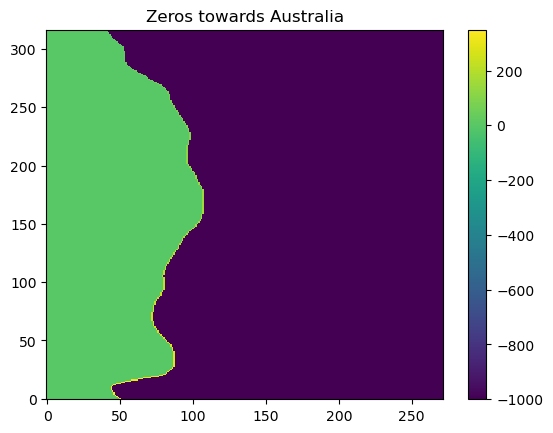

In [35]:
#FS and this is the original. Zeroes are towards Australia
plt.pcolormesh(contour_mask.xi_rho, contour_mask.eta_rho, contour_masked_above)
plt.colorbar();
plt.title('Zeros towards Australia');

In [36]:
# make halos: add 2 extra rows with the value of the last/first columns of the original
# The halo matrix has to be created according with your domain orientation.
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, 0]  # Inverted this one
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, -1] # with this one!

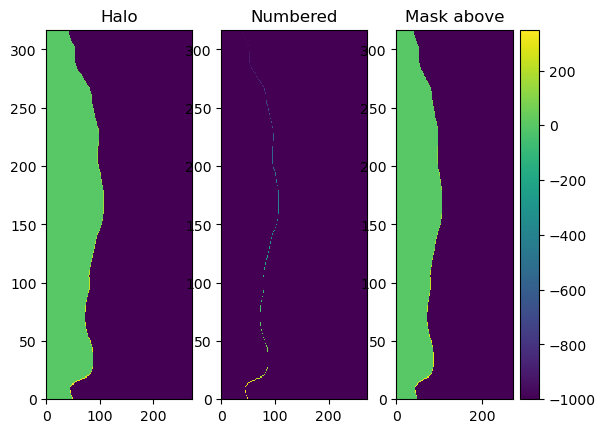

In [37]:
fig, ax = plt.subplots(ncols=3)
ax[0].pcolor(contour_masked_above_halo); ax[0].set_title('Halo');
ax[1].pcolor(contour_mask_numbered); ax[1].set_title('Numbered');
pc = ax[2].pcolor(contour_masked_above); plt.colorbar(pc)
ax[2].set_title('Mask above');

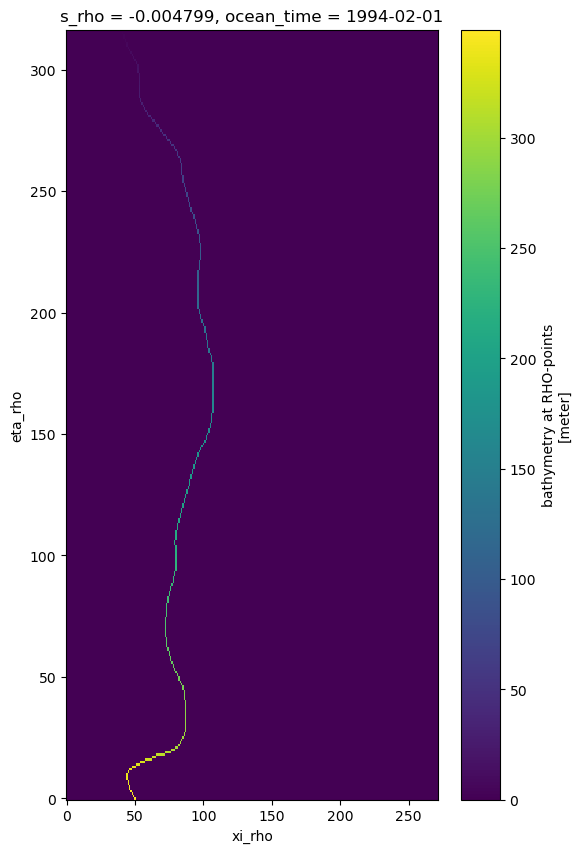

In [89]:
# To confirm that for CONTOUR_MASK_NUMBERED gaps from the figure above are just a plot window size arctifact, and the values does exist.
fig, ax = plt.subplots(figsize=(6, 10))
contour_mask_numbered.plot(ax=ax)

In [38]:
new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    print(mask_loc, index_j, index_i)

1 [316] [41]
2 [315] [41]
3 [314] [42]
4 [313] [42]
5 [312] [43]
6 [311] [44]
7 [310] [44]
8 [309] [45]
9 [308] [46]
10 [307] [47]
11 [306] [48]
12 [305] [49]
13 [304] [50]
14 [303] [51]
15 [302] [52]
16 [301] [52]
17 [300] [52]
18 [299] [52]
19 [298] [53]
20 [297] [53]
21 [296] [53]
22 [295] [53]
23 [294] [53]
24 [293] [53]
25 [292] [53]
26 [291] [53]
27 [290] [53]
28 [289] [53]
29 [288] [54]
30 [287] [54]
31 [286] [55]
32 [285] [56]
33 [284] [57]
34 [283] [58]
35 [282] [59]
36 [281] [60]
37 [281] [61]
38 [280] [62]
39 [279] [63]
40 [279] [64]
41 [278] [65]
42 [277] [66]
43 [277] [67]
44 [276] [68]
45 [275] [69]
46 [274] [70]
47 [273] [71]
48 [273] [72]
49 [272] [73]
50 [271] [74]
51 [271] [75]
52 [270] [76]
53 [269] [77]
54 [269] [78]
55 [268] [79]
56 [267] [80]
57 [266] [81]
58 [265] [81]
59 [264] [82]
60 [263] [83]
61 [262] [83]
62 [261] [84]
63 [260] [84]
64 [259] [84]
65 [258] [84]
66 [257] [84]
67 [256] [85]
68 [255] [85]
69 [254] [85]
70 [253] [86]
71 [252] [86]
72 [251] [87]
7

In [39]:
# make halos: add 2 extra rows with the value of the last/first columns of the original
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0]+2, shape[1]))
# FS: is this line the opposite? I think it has to be to avoid same numbered to be reconized
contour_masked_above_halo[0, :] = contour_masked_above[-1, :]  
contour_masked_above_halo[1:-1, :] = contour_masked_above
# FS: is this line the opposite?
contour_masked_above_halo[-1, :] = contour_masked_above[0, :] 


import numpy.ma as ma

# Direction of cross-contour transport
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)


new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    print('Count number %s' % mask_loc)
    
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j, index_i+1]==0) and (contour_masked_above[index_j, index_i-1]!=0):
        print('Into x: %s' % new_number_count)
        mask_x_transport[index_j, index_i] = -1
        # important to do 
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]!=0):
        print('Into x: %s' % new_number_count)
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

    
    
    # # if point below and point above are BOTH towards Antarctica:
    # # take transport grid point to south of t grid:
    # elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]==0):
    #     mask_x_transport[index_j, index_i-1] = 1
    #     mask_x_transport[index_j, index_i] = -1        
    #     mask_x_transport_numbered[index_j, index_i-1] = new_number_count
    #     mask_x_transport_numbered[index_j, index_i] = new_number_count+1
    #     new_number_count += 2
    
    
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j+2, index_i]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        print('Into y: %s' % new_number_count)
        mask_y_transport[index_j, index_i] = -1
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1

    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j+2, index_i]!=0):
        print('Into y: %s' % new_number_count)
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1


    # # if point to left and right BOTH toward Antarctica
    # elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j+2, index_i]==0):
    #     mask_y_transport[index_j-1, index_i] = 1
    #     mask_y_transport[index_j, index_i] = -1        
    #     mask_y_transport_numbered[index_j-1, index_i] = new_number_count
    #     mask_y_transport_numbered[index_j, index_i] = new_number_count+1
    #     new_number_count += 2

Count number 1
Into x: 1
Into y: 2
Count number 2
Into x: 3
Into y: 4
Count number 3
Into x: 5
Count number 4
Into x: 6
Into y: 7
Count number 5
Into x: 8
Into y: 9
Count number 6
Into x: 10
Count number 7
Into x: 11
Into y: 12
Count number 8
Into x: 13
Into y: 14
Count number 9
Into x: 15
Into y: 16
Count number 10
Into x: 17
Into y: 18
Count number 11
Into x: 19
Into y: 20
Count number 12
Into x: 21
Into y: 22
Count number 13
Into x: 23
Into y: 24
Count number 14
Into x: 25
Into y: 26
Count number 15
Into x: 27
Count number 16
Into x: 28
Count number 17
Into x: 29
Count number 18
Into x: 30
Into y: 31
Count number 19
Into x: 32
Count number 20
Into x: 33
Count number 21
Into x: 34
Count number 22
Into x: 35
Count number 23
Into x: 36
Count number 24
Into x: 37
Count number 25
Into x: 38
Count number 26
Into x: 39
Count number 27
Into x: 40
Count number 28
Into x: 41
Into y: 42
Count number 29
Into x: 43
Count number 30
Into x: 44
Into y: 45
Count number 31
Into x: 46
Into y: 47
Count

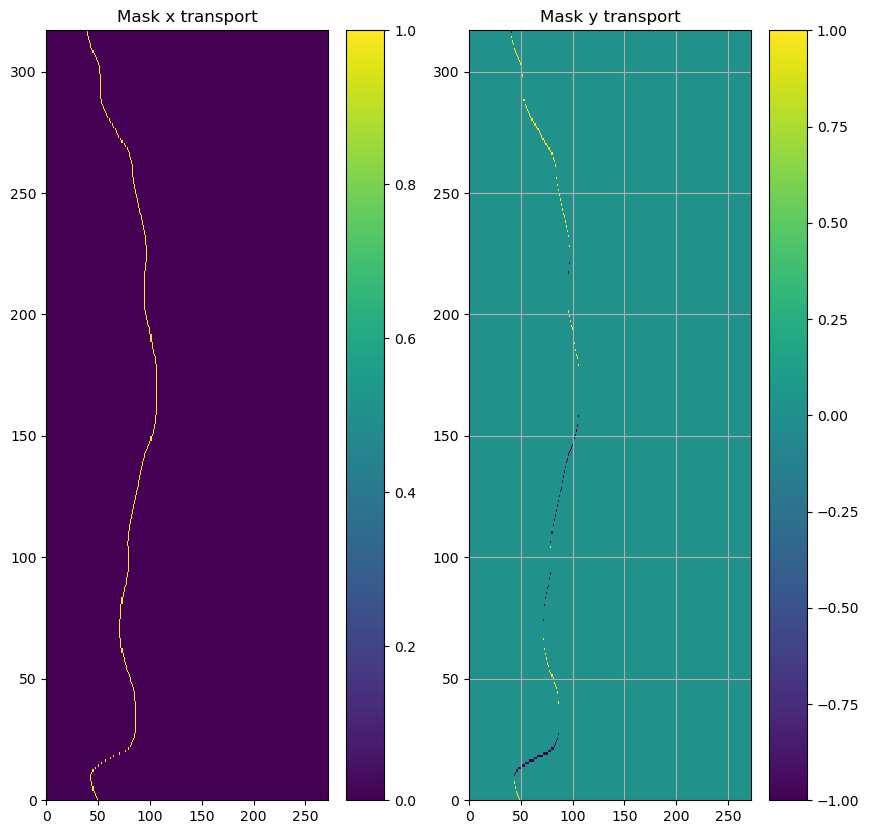

In [91]:
# Becarefull with the window size arctifact that avoid some cells to be added to the mask, leaving a gap that actually does not exist. With a better window size, we avoid that. This is specially for the xtransport.
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
ax0 = ax[0].pcolor(mask_x_transport);plt.colorbar(ax0); ax[0].set_title('Mask x transport');
ax1 = ax[1].pcolor(mask_y_transport); plt.colorbar(ax1); plt.grid(True); ax[1].set_title('Mask y transport');

In [41]:
# fig, ax = plt.subplots(ncols=2, figsize=(8,6))
# ax0 = ax[0].pcolor(mask_x_transport);plt.colorbar(ax0); 
# ax1 = ax[1].pcolor(mask_y_transport); plt.colorbar(ax1); plt.grid(True)

In [42]:
print(pm.shape, pn.shape)

(317, 272) (317, 272)


In [43]:
# # This is Fabio's adaptation. It is his way of interpolation from rho to u/v grid

# import pyresample

# rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
# u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
# v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)


# wf = lambda r: 1/r

# mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport,u_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport,v_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered,u_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered,v_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)


# # Convert contour masks to data arrays, so we can multiply them later.
# # We need to ensure the lat lon coordinates correspond to the actual data location:
# # The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
# # The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
# # However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
# # to make concatenation of transports in both direction and sorting possible.
# coordinates=dict(one=lon_rho, two=lat_rho)
# coordinatesU=dict(one=lon_u, two=lat_u)
# coordinatesV=dict(one=lon_v, two=lat_v)


# mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
# mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
# mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
# mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])

# # rename dimensions as simply eta/xi
# mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
# mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})
# mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
# mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})




In [46]:
# mask_x_transport_Ugrd.shape, mask_y_transport_Vgrd.shape 

In [95]:
# This is Fabio's adaptation. It is his way of interpolation from rho to u/v grid
# FS: this part differently from Fabios analysis, I adjusted to my diagnostic variables which are placed at rho points.
import pyresample

rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)


wf = lambda r: 1/r

mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport, rho_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport, rho_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered, rho_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered, rho_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)


# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
# The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
# The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
# However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
# to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)
coordinatesU=dict(one=lon_u, two=lat_u)
coordinatesV=dict(one=lon_v, two=lat_v)


# -->> For the use of the DIAGNOSTIC output <<--
mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinates, dims = ['eta_rho', 'xi_rho'])

# rename dimensions as simply eta/xi
mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_rho': 'eta','xi_rho': 'xi'})

In [96]:
mask_x_transport_Ugrd.shape, mask_y_transport_Vgrd.shape 

((317, 272), (317, 272))

In [97]:
mask_x_transport_Ugrd, mask_y_transport_Vgrd

(<xarray.DataArray (eta: 317, xi: 272)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
     one      (eta, xi) float64 147.1 147.1 147.2 147.2 ... 162.1 162.2 162.2
     two      (eta, xi) float64 -38.5 -38.51 -38.52 ... -28.13 -28.15 -28.16
 Dimensions without coordinates: eta, xi,
 <xarray.DataArray (eta: 317, xi: 272)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
     one      (eta, xi) float64 147.1 147.1 147.2 147.2 ... 162.1 162.2 162.2
     two      (eta, xi) float64 -38.5 -38.51 -38.52 ... -28.13 -28.15 -28.16
 Dimensions without coordinates: eta, xi)

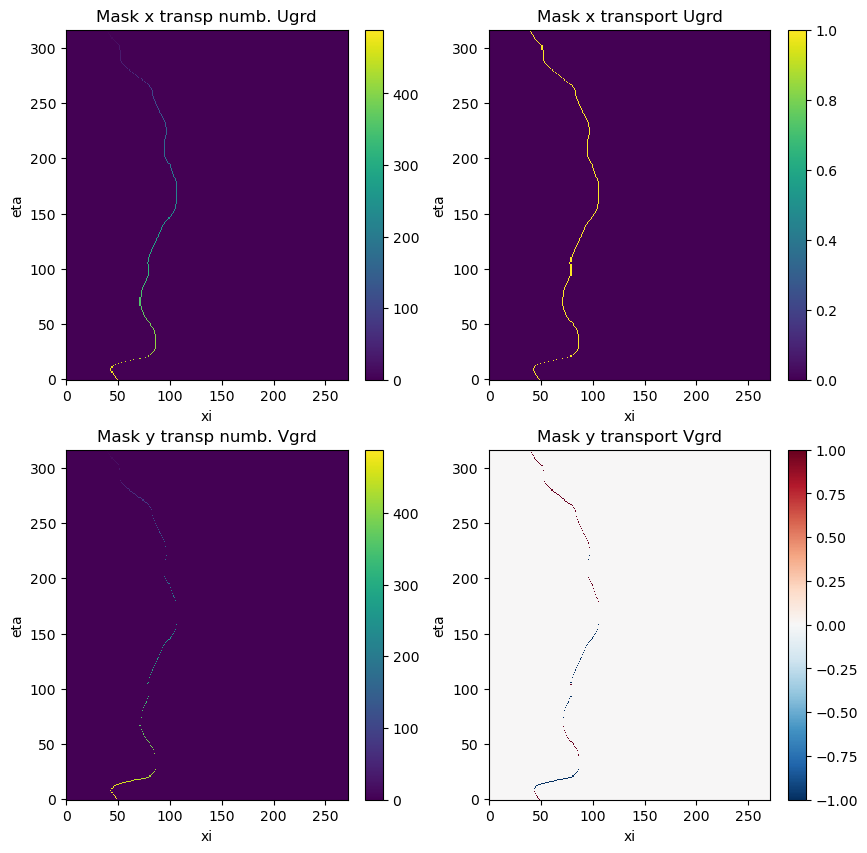

In [98]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
mask_x_transport_numbered_Ugrd.plot(ax=ax[0, 0]); ax[0,0].set_title('Mask x transp numb. Ugrd');
mask_x_transport_Ugrd.plot(ax=ax[0, 1]); ax[0,1].set_title('Mask x transport Ugrd');
mask_y_transport_numbered_Vgrd.plot(ax=ax[1, 0]); ax[1,0].set_title('Mask y transp numb. Vgrd');
mask_y_transport_Vgrd.plot(ax=ax[1, 1]); ax[1,1].set_title('Mask y transport Vgrd');

In [189]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
# dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
# *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
# but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
# FS: doing this we will get the (x, y) for the contour points as tuples
mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True) # will remove all the zeros

mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)  # will remove all the zeros

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [100]:
ds

<xarray.Dataset>
Dimensions:                         (tracer: 2, boundary: 4, s_rho: 30,
                                     s_w: 31, eta_rho: 317, xi_rho: 272,
                                     eta_u: 317, xi_u: 271, eta_v: 316,
                                     xi_v: 272, eta_psi: 316, xi_psi: 271,
                                     ocean_time: 30)
Coordinates: (12/13)
  * s_rho                           (s_rho) float64 -0.9715 ... -0.004799
  * s_w                             (s_w) float64 -1.0 -0.9433 ... -0.01 0.0
    lon_rho                         (eta_rho, xi_rho) float64 147.1 ... 162.2
    lat_rho                         (eta_rho, xi_rho) float64 -38.5 ... -28.16
    lon_u                           (eta_u, xi_u) float64 ...
    lat_u                           (eta_u, xi_u) float64 ...
    ...                              ...
    lat_v                           (eta_v, xi_v) float64 ...
    lon_psi                         (eta_psi, xi_psi) float64 ...
    lat_psi                         (eta_psi, xi_psi) float64 ...
  * ocean_time                      (ocean_time) datetime64[ns] 1994-02-01 .....
  * eta_rho                         (eta_rho) int64 0 1 2 3 ... 313 314 315 316
  * xi_rho                          (xi_rho) int64 0 1 2 3 4 ... 268 269 270 271
Dimensions without coordinates: tracer, boundary, eta_u, xi_u, eta_v, xi_v,
                                eta_psi, xi_psi
Data variables: (12/147)
    ntimes                          int32 ...
    ndtfast                         int32 ...
    dt                              float64 ...
    dtfast                          float64 ...
    dstart                          datetime64[ns] ...
    nHIS                            int32 ...
    ...                              ...
    mask_x_transport_numbered       (eta_rho, xi_rho) float64 0.0 0.0 ... 0.0
    mask_y_transport_numbered       (eta_rho, xi_rho) float64 0.0 0.0 ... 0.0
    mask_x_transport_Ugrd           (eta_u, xi_u) float64 0.0 0.0 ... 0.0 0.0
    mask_y_transport_Vgrd           (eta_v, xi_v) float64 0.0 0.0 ... 0.0 0.0
    mask_x_transport_Ugrd_numbered  (eta_u, xi_u) float64 0.0 0.0 ... 0.0 0.0
    mask_y_transport_Vgrd_numbered  (eta_v, xi_v) float64 0.0 0.0 ... 0.0 0.0
Attributes: (12/34)
    file:              outer_dia.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS diagnostics file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Thursday - November 23, 2023 -...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...

In [101]:
# Starting the test with the (bad) calculation of the HEAT TRANSPORT
# temp = ds.temp.isel(ocean_time=0)
# v = ds.v_northward.isel(ocean_time=0)
# u = ds.u_eastward.isel(ocean_time=0)

# FS: test for the diagnostic output.
temp_rate = ds.temp_rate.isel(ocean_time=0)
temp_xadv = ds.temp_xadv.isel(ocean_time=0)
temp_yadv = ds.temp_yadv.isel(ocean_time=0)
temp_vadv = ds.temp_vadv.isel(ocean_time=0)
temp_xdiff = ds.temp_xdiff.isel(ocean_time=0)
temp_ydiff = ds.temp_ydiff.isel(ocean_time=0)
temp_vdiff = ds.temp_vdiff.isel(ocean_time=0)
volume = ds_metric.dx * ds_metric.dy * ds_metric.dz.isel(ocean_time=0)   # dz its varying in time due to the free surface


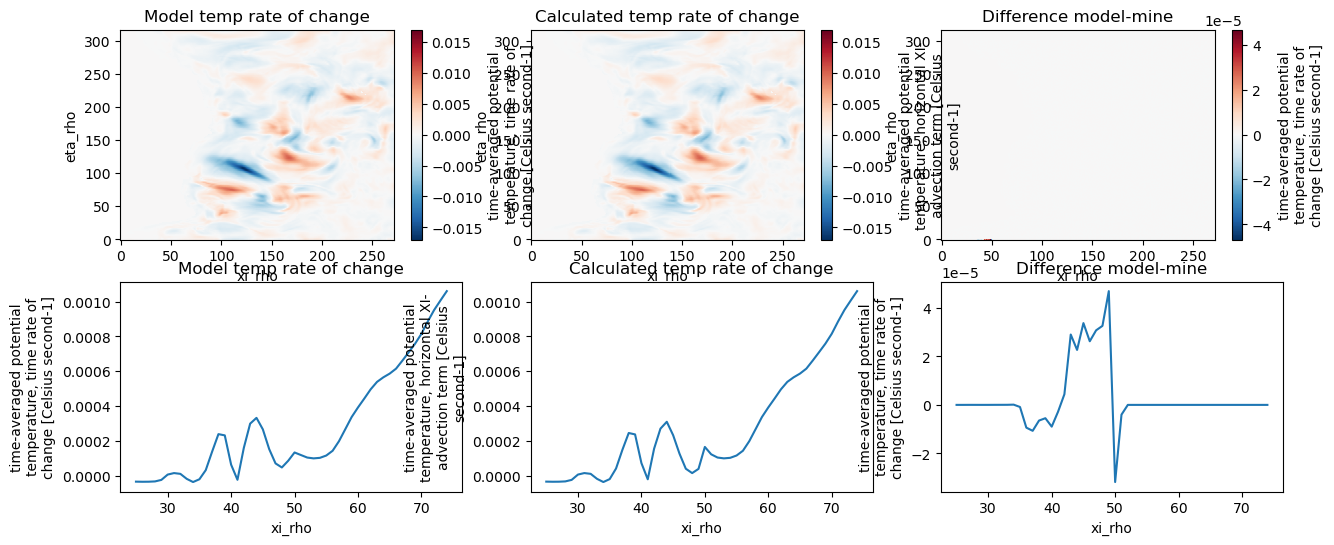

In [102]:
# Comparing vertically integrated Temp tendency from model and as the sum of the terms

# Model vertical integral
dz = ds_metric.dz.isel(ocean_time=0)
int_temp_rate = (temp_rate * dz).sum('s_rho')

# My calculation vertically integrated
my_int_temp_rate = (temp_xadv * dz).sum('s_rho') + (temp_yadv * dz).sum('s_rho') + (temp_vadv * dz).sum('s_rho') + (temp_xdiff * dz).sum('s_rho') + (temp_ydiff * dz).sum('s_rho') + (temp_vdiff * dz).sum('s_rho')

# Plot comparing
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))

# First row with maps
int_temp_rate.plot(ax=ax[0, 0]); ax[0, 0].set_title('Model temp rate of change');
my_int_temp_rate.plot(ax=ax[0, 1]); ax[0, 1].set_title('Calculated temp rate of change');
(int_temp_rate - my_int_temp_rate).plot(ax=ax[0, 2]); ax[0, 2].set_title('Difference model-mine');

# Second row looking closer to the only difference in the grid (it is just the first row that has this difference)
int_temp_rate.isel(xi_rho=slice(25, 75), eta_rho=slice(0, 1)).plot(ax=ax[1, 0]); ax[1, 0].set_title('Model temp rate of change');
my_int_temp_rate.isel(xi_rho=slice(25, 75), eta_rho=slice(0, 1)).plot(ax=ax[1, 1]); ax[1, 1].set_title('Calculated temp rate of change');
(int_temp_rate - my_int_temp_rate).isel(xi_rho=slice(25, 75), eta_rho=slice(0, 1)).plot(ax=ax[1, 2]); ax[1, 2].set_title('Difference model-mine');

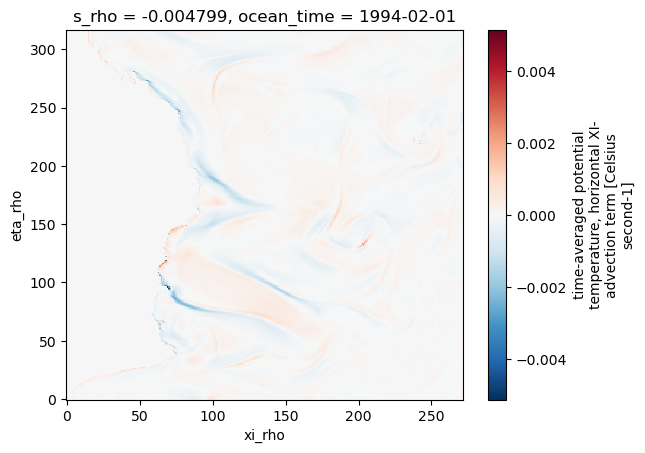

In [103]:
# To have a look into the magnitude
temp_xadv.isel(s_rho=-1).plot()

In [104]:
# # determine constants:
# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1


# # Bad calculation of heat transport, due to the use of rho points for temp when I have u/v in their origianl location!!!! FS
# v_heat_trans = (temp * v * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice).rename({'eta_rho': 'eta','xi_rho': 'xi'})
# u_heat_trans = (temp * u * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice).rename({'eta_rho': 'eta','xi_rho': 'xi'})


# # temporary while rho and u/v grid are not properly set
# u_heat_trans = u_heat_trans.isel(xi=slice(0, -1))
# v_heat_trans = v_heat_trans.isel(eta=slice(0, -1))



In [105]:
# fig, ax = plt.subplots(ncols=2)
# u_heat_trans.isel(s_rho=-1).plot(ax=ax[0]); ax[0].set_title('U Heat flux');
# v_heat_trans.isel(s_rho=-1).plot(ax=ax[1]); ax[1].set_title('V Heat flux');

In [106]:
mask_x_numbered_1d

<xarray.DataArray (contour_index: 317)>
array([489., 487., 485., 483., 481., 480., 478., 477., 475., 474., 472.,
       470., 468., 465., 461., 457., 452., 446., 442., 435., 429., 425.,
       422., 420., 418., 416., 415., 413., 412., 411., 410., 409., 408.,
       407., 406., 405., 404., 403., 402., 401., 400., 398., 397., 396.,
       395., 393., 392., 390., 388., 386., 385., 383., 381., 379., 377.,
       376., 374., 372., 371., 369., 368., 366., 365., 363., 362., 361.,
       360., 358., 357., 356., 355., 354., 353., 352., 350., 349., 348.,
       347., 346., 345., 343., 342., 341., 339., 338., 336., 335., 333.,
       331., 330., 329., 327., 326., 324., 323., 322., 321., 320., 319.,
       318., 317., 316., 315., 314., 313., 311., 309., 308., 307., 306.,
       304., 303., 302., 300., 299., 297., 296., 294., 293., 291., 290.,
       288., 287., 285., 284., 282., 281., 279., 277., 276., 275., 273.,
       272., 270., 269., 267., 266., 264., 263., 261., 259., 258., 256.,
       254., 252., 250., 248., 246., 245., 243., 241., 240., 238., 237.,
       235., 234., 233., 232., 230., 229., 228., 227., 226., 225., 224.,
       223., 222., 221., 220., 219., 218., 217., 216., 215., 214., 213.,
       212., 211., 210., 209., 207., 206., 205., 203., 201., 200., 198.,
       197., 196., 194., 193., 192., 190., 189., 188., 186., 184., 183.,
       181., 180., 178., 177., 175., 174., 173., 172., 171., 170., 169.,
       168., 167., 166., 165., 164., 163., 162., 161., 159., 158., 157.,
       156., 154., 153., 152., 151., 150., 149., 148., 147., 145., 144.,
       143., 142., 140., 139., 137., 136., 134., 133., 131., 130., 128.,
       126., 125., 123., 122., 120., 119., 117., 116., 114., 113., 111.,
       110., 108., 107., 106., 104., 103., 102., 101., 100.,  98.,  97.,
        95.,  93.,  92.,  90.,  88.,  85.,  83.,  80.,  78.,  75.,  73.,
        71.,  69.,  66.,  64.,  61.,  59.,  56.,  54.,  52.,  50.,  48.,
        46.,  44.,  43.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,  34.,
        33.,  32.,  30.,  29.,  28.,  27.,  25.,  23.,  21.,  19.,  17.,
        15.,  13.,  11.,  10.,   8.,   6.,   5.,   3.,   1.])
Coordinates:
    one            (contour_index) float64 148.6 148.6 148.6 ... 153.9 153.9
    two            (contour_index) float64 -38.92 -38.87 ... -25.51 -25.47
  * contour_index  (contour_index) object MultiIndex
  * eta            (contour_index) int64 0 1 2 3 4 5 ... 311 312 313 314 315 316
  * xi             (contour_index) int64 49 48 47 46 45 45 ... 43 42 41 41 40 40

In [107]:
temp_xadv.shape, np.shape(mask_x_transport_Ugrd)

((30, 317, 272), (317, 272))

In [60]:
# fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
# u_heat_trans.isel(s_rho=-1).plot(ax=ax[0], vmin=-2e7, vmax=2e7, cmap='RdBu'); ax[0].set_title('U Heat flux');

# for vv in mask_x_numbered_1d.contour_index.values:
#     ax[0].plot(vv[1], vv[0], 'ok', alpha=0.1);
# p1= ax[1].pcolor(u_heat_trans.isel(s_rho=-1) * mask_x_transport_Ugrd, vmin=-2e7, vmax=2e7, cmap='RdBu'); # u points
# plt.colorbar(p1); ax[1].set_title('Heat Flux with the mask x applied')

# p2 = ax[2].pcolor(mask_x_transport_Ugrd, cmap='bwr'); ax[2].set_title('Mask x applied'); # u points
# plt.colorbar(p2);

In [61]:
# fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
# v_heat_trans.isel(s_rho=-1).plot(ax=ax[0], vmin=-2e7, vmax=2e7, cmap='RdBu'); ax[0].set_title('V Heat flux');
# for vv in mask_y_numbered_1d.contour_index.values:
#     ax[0].plot(vv[1], vv[0], 'ok', alpha=0.2);
# p1= ax[1].pcolor(v_heat_trans.isel(s_rho=-1) * mask_y_transport_Vgrd, vmin=-2e7, vmax=2e7, cmap='RdBu'); # v points
# plt.colorbar(p1); ax[1].set_title('Heat Flux with the mask y applied')
# p2 = ax[2].pcolor(mask_y_transport_Vgrd, cmap='bwr'); ax[2].set_title('Mask y applied');
# plt.colorbar(p2);

In [205]:

def extract_transp_across_contour(temp, var_x, var_y):   # var:4D [time,eta_rho,xi_rho]
    '''
    The input attributes:

    - temp: it is used here just to get the time dimension
    - var_x and var_y: it is the x and y wrt the variable being used, in my case temp_adv/temp_diff
    FS comment and a few adaptations.
    '''

    zlen = len(temp[:,0,0])
    tlen = 1
    # print(tlen,zlen)
    transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

    for tt in range(0,tlen): # loop through time
        for zz in range(0,zlen): # loop through z-levels

            print('Debugging high memory usage: ')
            print('Time: %s, and Sigma level: %s' % (tt, zz))

            # U and V points
            # var_x_tmp = var_x.isel(s_rho=zz) * mask_x_transport_Ugrd
            # var_y_tmp = var_y.isel(s_rho=zz) * mask_y_transport_Vgrd

            # In case you need to extract only the ".values" to avoid problem with memory... FS 11th jan 2024
            var_x_tmp = var_x.isel(s_rho=zz).values * mask_x_transport_Ugrd
            var_y_tmp = var_y.isel(s_rho=zz).values * mask_y_transport_Vgrd
            
            print('var_x_tmp/var_y_tmp shapes after mask multip.: %s, %s' % (var_x_tmp.shape, var_y_tmp.shape))
            
            # fig, ax = plt.subplots(ncols=2)
            # p0 = ax[0].pcolor(var_x_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p0)
            # p1 = ax[1].pcolor(var_y_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p1)

            # stack transports into 1d and drop any points not on contour:
            # 'CONTOUR_INDEX' keeps the (row, col) position, so even when you drop values, you have the location
            x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
            x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d > 0, drop = True)
            y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
            y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d > 0, drop = True)

            print('x_var_1d_tmp/y_var_1d_tmp shapes after stack: %s, %s' % (x_var_1d_tmp.shape, y_var_1d_tmp.shape))

            # ORIGINAL combine all points on contour:
            transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
            # transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
            transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
            transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            transp_across_contour_tmp = transp_across_contour_tmp.load()
          
            # print(tt, zz, transp_across_contour_tmp.shape)
            transp_across_contour[tt,zz,:] = transp_across_contour_tmp
            del transp_across_contour_tmp

    return transp_across_contour.squeeze()  # getting rid of unit dimention

In [206]:
# # testing!! FS Jan 15, 24

# temp_xterms = temp_xadv + temp_xdiff
# temp_yterms = temp_yadv + temp_ydiff
# # transp_across_contour = extract_transp_across_contour(temp_rate, temp_xterms, temp_yterms) 


# zlen = len(temp_rate[:,0,0])
# tlen = 1
# # print(tlen,zlen)
# transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

# for tt in range(0,tlen): # loop through time
#     for zz in range(0,zlen): # loop through z-levels

#         print('Debugging high memory usage: ')
#         print('Time: %s, and Sigma level: %s' % (tt, zz))

#         # In case you need to extract only the ".values" to avoid problem with memory... FS 11th jan 2024
#         var_x_tmp = temp_xterms.isel(s_rho=zz).values * mask_x_transport_Ugrd
#         var_y_tmp = temp_yterms.isel(s_rho=zz).values * mask_y_transport_Vgrd
        

#         print('var_x_tmp/var_y_tmp shapes after mask multip.: %s, %s' % (var_x_tmp.shape, var_y_tmp.shape))
        
#         # fig, ax = plt.subplots(ncols=2)
#         # p0 = ax[0].pcolor(var_x_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p0)
#         # p1 = ax[1].pcolor(var_y_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p1)


#         # stack transports into 1d and drop any points not on contour:
#         # 'CONTOUR_INDEX' keeps the (row, col) position, so even when you drop values, you have the location
#         x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
#         x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d > 0, drop = True)
#         y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
#         y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d > 0, drop = True)

#         print('x_var_1d_tmp/y_var_1d_tmp shapes after stack: %s, %s' % (x_var_1d_tmp.shape, y_var_1d_tmp.shape))

#         # combine all points on contour:
#         transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
#         # transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
#         transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
#         transp_across_contour_tmp.coords['contour_index'] = contour_index_array
#         transp_across_contour_tmp = transp_across_contour_tmp.load()

        
#         # # print(tt, zz, transp_across_contour_tmp.shape)
#         # transp_across_contour[tt,zz,:] = transp_across_contour_tmp
#         del transp_across_contour_tmp

In [207]:
# transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
# # transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
# transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
# # transp_across_contour_tmp.coords['contour_index'] = contour_index_array
# # transp_across_contour_tmp = transp_across_contour_tmp.load()
# transp_across_contour_tmp.contour_index.values

In [208]:

# transp_across_contour = extract_transp_across_contour(temp, u_heat_trans, v_heat_trans)
temp_xterms = temp_xadv + temp_xdiff
temp_yterms = temp_yadv + temp_ydiff
transp_across_contour = extract_transp_across_contour(temp_rate, temp_xterms, temp_yterms) 

Debugging high memory usage: 
Time: 0, and Sigma level: 0
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 1
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 2
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 3
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 4
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level:

/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 6
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 7
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 8
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 9
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 10
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), 

/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 12
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 13
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 14
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 15
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 16
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 17
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 18
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 19
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 20
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 21
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317

/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 23
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 24
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 25
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 26
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)
Debugging high memory usage: 
Time: 0, and Sigma level: 27
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317

/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (172,)


/tmp/ipykernel_412/1102003318.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array


In [216]:
transp_across_contour.sum(axis=0).cumsum()

(489,)

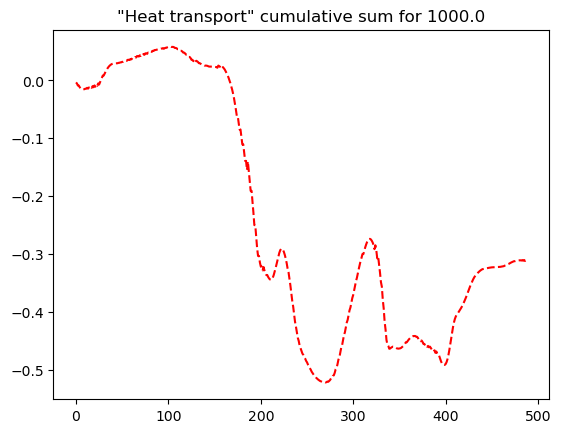

In [222]:
# The heat transport is not correct because the grid metrics is not being used to properly calculate the magnitude
heat_cumsum_fabio = np.sum(np.cumsum(transp_across_contour, axis=1),axis=0)

plt.plot(heat_cumsum_fabio, '--r')
plt.title(f'"Heat transport" cumulative sum for {contour_depth}');

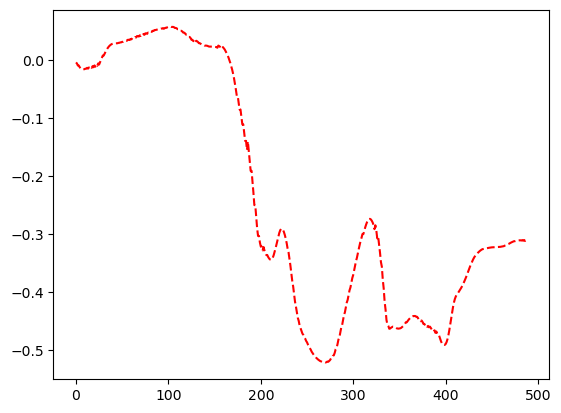

In [223]:
#FS: Summing across depth and cumulative sum per latitude
mine = transp_across_contour.sum(axis=0).cumsum()

plt.plot(mine, 'r--');

In [226]:
lon_along_contour = contour_ordering.one
lat_along_contour = contour_ordering.two

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array



In [ ]:
''' STILL NEEDS ADAPTATION TO MY ROMS!!'''

%%time
# if there is a bend in the contour, add the distance using the half-length of the diagonal
# instead of the sum of 2 edges, to be more representative.
distance_along_contour = np.zeros((num_points))

x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])

skip = False
# note dxu and dyt do not vary in x, so we can just take the first value (as long as there is no land there,
# which for this latitude range there is not. If using a different latitude range, choose an x value that is
# not a nan/land for the entire latitude range
dxu = dxu.isel(xu_ocean = 0)
dyt = dyt.isel(xt_ocean = 0)

for count in range(1, num_points):
    if skip == True:
        skip = False
        continue
    if count in y_indices:
        if count + 1 in y_indices:
            # note dxu and dyt do not vary in x:
            jj = np.where(mask_y_transport_numbered==count)[0]
            distance_along_contour[count-1] = (dxu[jj])[0]
        else:
            jj0 = np.where(mask_y_transport_numbered==count)[0]
            jj1 = np.where(mask_x_transport_numbered==count+1)[0]
            half_diagonal_distance = 0.5 * np.sqrt((dxu[jj0])[0]**2 + (dyt[jj1])[0]**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

    # count in x_indices:
    else:
        if count + 1 in x_indices:
            jj = np.where(mask_x_transport_numbered==count)[0]
            distance_along_contour[count-1] = (dyt[jj])[0]
        else:
            jj0 = np.where(mask_x_transport_numbered==count)[0]
            jj1 = np.where(mask_y_transport_numbered==count+1)[0]
            half_diagonal_distance = 0.5 * np.sqrt((dyt[jj0])[0]**2 + (dxu[jj1])[0]**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

# fix last value:
if distance_along_contour[-1] == 0:
    count = count + 1
    if count in y_indices:
        jj = np.where(mask_y_transport_numbered==count)[0]
        distance_along_contour[-1] = (dxu[jj])[0]
    else:
        jj = np.where(mask_x_transport_numbered==count)[0]
        distance_along_contour[-1] = (dyt[jj])[0]

# units are 10^3 km:
distance_along_contour = np.cumsum(distance_along_contour) / 1e3 / 1e3

### This is my method of interpolation. Comparing the two final figures of heat cumsum they look very similar. However, the final arrays have a difference of one element between my method and his.  

In [65]:
# FS: my method to interpolate the mask into different grid
mask_x_transportDA = xr.DataArray(mask_x_transport, coords={'eta_rho': ds.eta_rho.data, 'xi_rho': ds.xi_rho.data,
                                             'lat_rho': (('eta_rho', 'xi_rho'), lat_rho.data),
                                             'lon_rho': (('eta_rho', 'xi_rho'), lon_rho.data)}, dims=['eta_rho', 'xi_rho'])
mask_y_transportDA = xr.DataArray(mask_y_transport, coords={'eta_rho': ds.eta_rho.data, 'xi_rho': ds.xi_rho.data,
                                             'lat_rho': (('eta_rho', 'xi_rho'), lat_rho.data),
                                             'lon_rho': (('eta_rho', 'xi_rho'), lon_rho.data)}, dims=['eta_rho', 'xi_rho'])
mask_x_transportDA_numbered = xr.DataArray(mask_x_transport_numbered, coords={'eta_rho': ds.eta_rho.data, 'xi_rho': ds.xi_rho.data,
                                             'lat_rho': (('eta_rho', 'xi_rho'), lat_rho.data),
                                             'lon_rho': (('eta_rho', 'xi_rho'), lon_rho.data)}, dims=['eta_rho', 'xi_rho'])
mask_y_transportDA_numbered = xr.DataArray(mask_y_transport_numbered, coords={'eta_rho': ds.eta_rho.data, 'xi_rho': ds.xi_rho.data,
                                             'lat_rho': (('eta_rho', 'xi_rho'), lat_rho.data),
                                             'lon_rho': (('eta_rho', 'xi_rho'), lon_rho.data)}, dims=['eta_rho', 'xi_rho'])
mask_x_transportDA, mask_y_transportDA

(<xarray.DataArray (eta_rho: 317, xi_rho: 272)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
   * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 7 ... 309 310 311 312 313 314 315 316
   * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 264 265 266 267 268 269 270 271
     lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
     lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2,
 <xarray.DataArray (eta_rho: 317, xi_rho: 272)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
   * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 7 ... 309 310 

In [66]:
ds['mask_x_transport'] = mask_x_transportDA
ds['mask_y_transport'] = mask_y_transportDA
ds['mask_x_transport_numbered'] = mask_x_transportDA_numbered
ds['mask_y_transport_numbered'] = mask_y_transportDA_numbered
ds

<xarray.Dataset>
Dimensions:                    (tracer: 2, boundary: 4, s_rho: 30, s_w: 31,
                                eta_rho: 317, xi_rho: 272, eta_u: 317,
                                xi_u: 271, eta_v: 316, xi_v: 272, eta_psi: 316,
                                xi_psi: 271, ocean_time: 30)
Coordinates: (12/13)
  * s_rho                      (s_rho) float64 -0.9715 -0.9156 ... -0.004799
  * s_w                        (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.01 0.0
    lon_rho                    (eta_rho, xi_rho) float64 147.1 147.1 ... 162.2
    lat_rho                    (eta_rho, xi_rho) float64 -38.5 -38.51 ... -28.16
    lon_u                      (eta_u, xi_u) float64 ...
    lat_u                      (eta_u, xi_u) float64 ...
    ...                         ...
    lat_v                      (eta_v, xi_v) float64 ...
    lon_psi                    (eta_psi, xi_psi) float64 ...
    lat_psi                    (eta_psi, xi_psi) float64 ...
  * ocean_time                 (ocean_time) datetime64[ns] 1994-02-01 ... 199...
  * eta_rho                    (eta_rho) int64 0 1 2 3 4 ... 312 313 314 315 316
  * xi_rho                     (xi_rho) int64 0 1 2 3 4 ... 267 268 269 270 271
Dimensions without coordinates: tracer, boundary, eta_u, xi_u, eta_v, xi_v,
                                eta_psi, xi_psi
Data variables: (12/143)
    ntimes                     int32 ...
    ndtfast                    int32 ...
    dt                         float64 ...
    dtfast                     float64 ...
    dstart                     datetime64[ns] ...
    nHIS                       int32 ...
    ...                         ...
    salt_vdiff                 (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_rate                  (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    mask_x_transport           (eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_y_transport           (eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_x_transport_numbered  (eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_y_transport_numbered  (eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/34)
    file:              outer_dia.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS diagnostics file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Thursday - November 23, 2023 -...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...

In [67]:
ds['mask_x_transport_Ugrd'] = ds.mask_x_transport.interp(eta_rho=ds.eta_u, xi_rho=ds.xi_u, method='nearest')
ds['mask_y_transport_Vgrd'] = ds.mask_y_transport.interp(eta_rho=ds.eta_v, xi_rho=ds.xi_v, method='nearest')
ds['mask_x_transport_Ugrd_numbered'] = ds.mask_x_transport_numbered.interp(eta_rho=ds.eta_u, xi_rho=ds.xi_u, method='nearest')
ds['mask_y_transport_Vgrd_numbered'] = ds.mask_y_transport_numbered.interp(eta_rho=ds.eta_v, xi_rho=ds.xi_v, method='nearest')
ds.mask_x_transport_Ugrd, ds.mask_x_transport, ds.mask_y_transport_Vgrd, ds.mask_y_transport


(<xarray.DataArray 'mask_x_transport_Ugrd' (eta_u: 317, xi_u: 271)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
     lon_u    (eta_u, xi_u) float64 ...
     lat_u    (eta_u, xi_u) float64 ...
 Dimensions without coordinates: eta_u, xi_u,
 <xarray.DataArray 'mask_x_transport' (eta_rho: 317, xi_rho: 272)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
     lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
     lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 7 ... 309 310

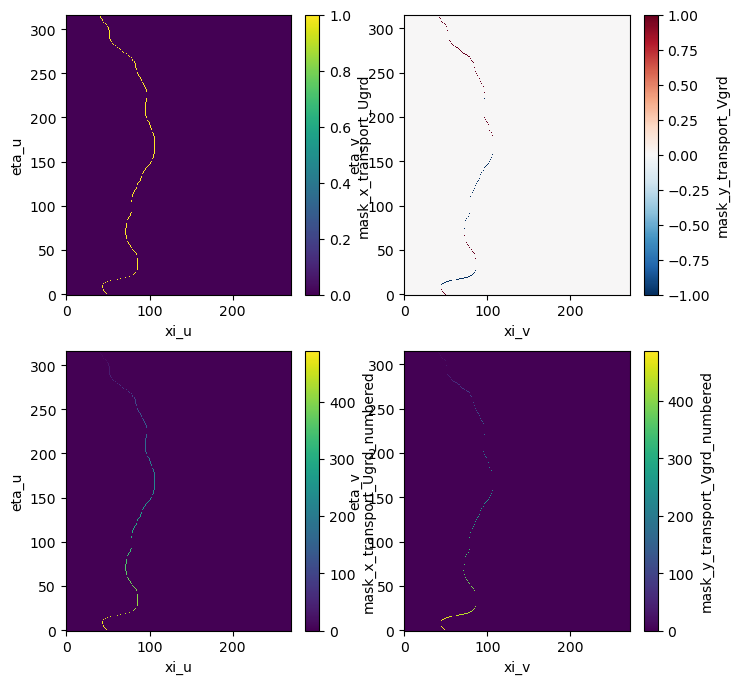

In [68]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
ds.mask_x_transport_Ugrd.plot(ax=ax[0, 0])
ds.mask_x_transport_Ugrd_numbered.plot(ax=ax[1, 0])
ds.mask_y_transport_Vgrd.plot(ax=ax[0, 1])
ds.mask_y_transport_Vgrd_numbered.plot(ax=ax[1, 1])

In [69]:
coordinates=dict(one=lon_rho, two=lat_rho)
coordinatesU=dict(one=lon_u, two=lat_u)
coordinatesV=dict(one=lon_v, two=lat_v)

mask_x_transport_Ugrd = xr.DataArray(ds.mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_Vgrd = xr.DataArray(ds.mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
mask_x_transport_Ugrd_numbered = xr.DataArray(ds.mask_x_transport_Ugrd_numbered, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_Vgrd_numbered = xr.DataArray(ds.mask_y_transport_Vgrd_numbered, coords = coordinatesV, dims = ['eta_v', 'xi_v'])


# rename dimensions as simply eta/xi
mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})
mask_x_transport_numbered_Ugrd = mask_x_transport_Ugrd_numbered.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_numbered_Vgrd = mask_y_transport_Vgrd_numbered.rename({'eta_v': 'eta','xi_v': 'xi'})

In [70]:
# FS: doing this we will get the (x, y) for the contour points as tuples
mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True) # will remove all the zeros

mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)  # will remove all the zeros

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [71]:
temp = ds.temp.isel(ocean_time=0)
v = ds.v_northward.isel(ocean_time=0)
u = ds.u_eastward.isel(ocean_time=0)

AttributeError: 'Dataset' object has no attribute 'temp'

In [ ]:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1


# Bad calculation of heat transport, due to the use of rho points for temp when I have u/v in their origianl location!!!! FS
v_heat_trans = (temp * v * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice).rename({'eta_rho': 'eta','xi_rho': 'xi'})
u_heat_trans = (temp * u * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice).rename({'eta_rho': 'eta','xi_rho': 'xi'})


# temporary while rho and u/v grid are not properly set
u_heat_trans = u_heat_trans.isel(xi=slice(0, -1))
v_heat_trans = v_heat_trans.isel(eta=slice(0, -1))

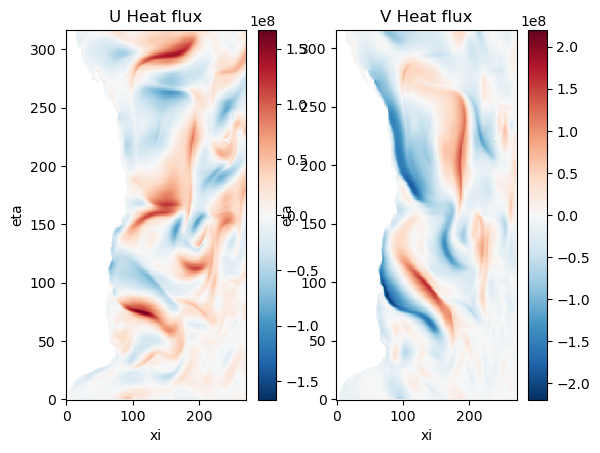

In [ ]:
fig, ax = plt.subplots(ncols=2)
u_heat_trans.isel(s_rho=-1).plot(ax=ax[0]); ax[0].set_title('U Heat flux');
v_heat_trans.isel(s_rho=-1).plot(ax=ax[1]); ax[1].set_title('V Heat flux');

In [ ]:
transp_across_contour = extract_transp_across_contour(temp, u_heat_trans, v_heat_trans)

Debugging high memory usage: 
Time: 0, and Sigma level: 0
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 1
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 2
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the fut

Debugging high memory usage: 
Time: 0, and Sigma level: 3
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 4
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 5
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 6
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 7
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 8
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 9
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 10
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 11
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 12


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 13
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 14
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 15
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 16
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 17
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 18
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 19
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 20
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 21
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 22
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


Debugging high memory usage: 
Time: 0, and Sigma level: 23
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 24
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 25
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 26
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 27
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 28
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 29
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 271), (316, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


Text(0.5, 1.0, '"Heat transport" cumulative sum for 1000.0')

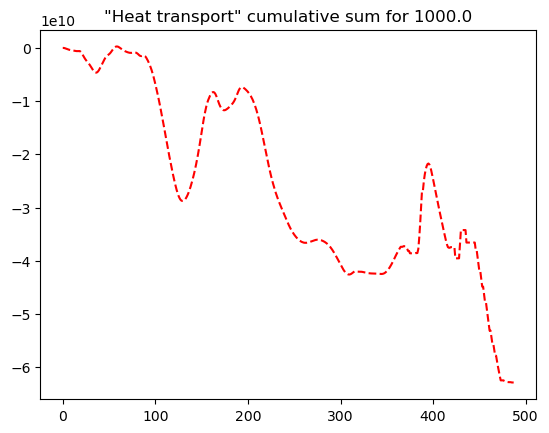

In [ ]:
# The heat transport is not correct because the grid metrics is not being used to properly calculate the magnitude
heat_cumsum = np.sum(np.cumsum(transp_across_contour, axis=1),axis=0)

plt.plot(heat_cumsum, '--r')
plt.title(f'"Heat transport" cumulative sum for {contour_depth}')

### Doing the calculation using the diagnostic output

In [ ]:

def extract_transp_across_contour(temp, var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[:,0,0])
    tlen = 1
    # print(tlen,zlen)
    transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

    for tt in range(0,tlen): # loop through time
        for zz in range(0,zlen): # loop through z-levels

            print('Debugging high memory usage: ')
            print('Time: %s, and Sigma level: %s' % (tt, zz))

            # U and V points
            var_x_tmp = var_x.isel(s_rho=zz) * mask_x_transport
            var_y_tmp = var_y.isel(s_rho=zz) * mask_y_transport
            
            print('var_x_tmp/var_y_tmp shapes after mask multip.: %s, %s' % (var_x_tmp.shape, var_y_tmp.shape))
            
            # fig, ax = plt.subplots(ncols=2)
            # p0 = ax[0].pcolor(var_x_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p0)
            # p1 = ax[1].pcolor(var_y_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p1)

            # stack transports into 1d and drop any points not on contour:
            x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
            x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
            y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
            y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

            print('x_var_1d_tmp/y_var_1d_tmp shapes after stack: %s, %s' % (x_var_1d_tmp.shape, y_var_1d_tmp.shape))

            # ORIGINAL combine all points on contour:
            transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
            transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
            transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
            transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            transp_across_contour_tmp = transp_across_contour_tmp.load()

            # Instead of concatenating, I'll assume for now that the total flux is flux_x + flux_y
            transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
            transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
            transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            transp_across_contour_tmp = transp_across_contour_tmp.load()
            
            # print(tt, zz, transp_across_contour_tmp.shape)
            transp_across_contour[tt,zz,:] = transp_across_contour_tmp
            del transp_across_contour_tmp

    return transp_across_contour.squeeze()  # getting rid of unit dimention

In [ ]:
# Reading the diagnostic file
dg = xr.open_dataset('/mnt/c/Users/z5392640/OneDrive - UNSW/Documents/PhD/scientific_topics/heat_budget/neil_nci/colette/outer_dia.nc')


In [ ]:
dg

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272,
                    eta_psi: 316, xi_psi: 271, ocean_time: 30)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 1994-02-01 ... 1994-03-02
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/139)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    salt_hdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_xdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_ydiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_sdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_vdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_rate      (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
Attributes: (12/34)
    file:              outer_dia.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS diagnostics file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Thursday - November 23, 2023 -...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...

In [ ]:
x_temp = dg.temp_xadv.isel(ocean_time=0).rename(eta_rho='eta', xi_rho='xi') + dg.temp_xdiff.isel(ocean_time=0).rename(eta_rho='eta', xi_rho='xi')
y_temp = dg.temp_yadv.isel(ocean_time=0).rename(eta_rho='eta', xi_rho='xi') + dg.temp_ydiff.isel(ocean_time=0).rename(eta_rho='eta', xi_rho='xi')

transp_across_contour = extract_transp_across_contour(temp, x_temp, y_temp)

Debugging high memory usage: 
Time: 0, and Sigma level: 0
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 1


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 2
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 3
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 4


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 5
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 6
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 7
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 8
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 9
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 10
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


Debugging high memory usage: 
Time: 0, and Sigma level: 11
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 12
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 13
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 14
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 15
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 16
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 17
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 18
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 19
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 20
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 21
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


Debugging high memory usage: 
Time: 0, and Sigma level: 22
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 23
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 24
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 25
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 26
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 27
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 28
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)
Debugging high memory usage: 
Time: 0, and Sigma level: 29
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})
/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


x_var_1d_tmp/y_var_1d_tmp shapes after stack: (317,), (171,)


/home/fsobral/miniforge3/envs/XROMS/lib/python3.8/site-packages/xarray/core/coordinates.py:46: FutureWarning: Updating MultiIndexed coordinate 'contour_index' would corrupt indices for other variables: ['eta', 'xi']. This will raise an error in the future. Use `.drop_vars({'contour_index', 'eta', 'xi'})` before assigning new coordinate values.
  self.update({key: value})


Text(0.5, 1.0, '"Heat transport" cumulative sum for 1000.0')

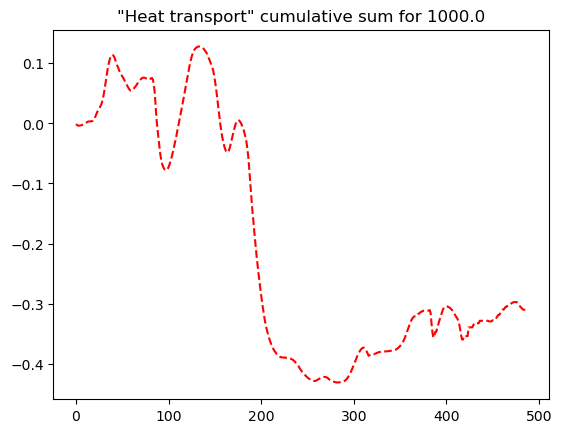

In [ ]:
'''NOT SURE ABOUT THE MAGNITUDE HERE.....'''



heat_cumsum = np.sum(np.cumsum(transp_across_contour, axis=1),axis=0)

plt.plot(heat_cumsum, '--r')
plt.title(f'"Heat transport" cumulative sum for {contour_depth}')

In [72]:
y_temp.isel(s_rho=-1).plot()

NameError: name 'y_temp' is not defined